In [1]:
import itertools, logging, re, string, sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

# Read Data

Read printer data into a DataFrame and subset it into those that already have VIAF IDs and those that don't. 

Plot total texts, texts with IDs, texts without IDs

In [2]:
printers_data_file = 'data/pre_1655_printers.csv'
printers_df = pd.read_csv(printers_data_file)

viaf_exists = printers_df[~printers_df['Entity Identifiers Column'].isna()]
viaf_needed = printers_df[printers_df['Entity Identifiers Column'].isna()]

Total Number of texts:  31,569
Texts with VIAF IDs:    15,947
Texts without VIAF IDs: 15,622


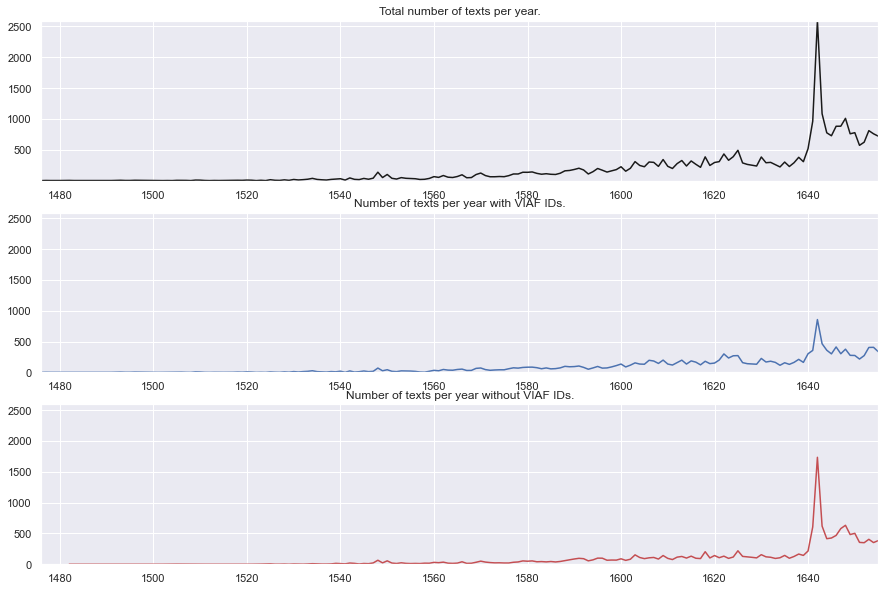

In [3]:
# Change these values to zoom in on shorter yearspans
start_year = 1400
end_year = 1660

total_counts = printers_df.groupby(['parsed_year'])['parsed_year'].count()
viaf_exists_counts = viaf_exists.groupby(['parsed_year'])['parsed_year'].count()
viaf_needed_counts = viaf_needed.groupby(['parsed_year'])['parsed_year'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if total_counts.index[0] < start_year else total_counts.index[0]
end_year = end_year if total_counts.index[-1] > end_year else total_counts.index[-1]
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts.values)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

# Parse Printer Names

Parse printer names in the VIAF needed dataframe to identify those most likely to be names. This can likely be done with some basic regex patterns that look for firstname/initial lastname/initial patterns. Once these names are identified, we'll try to cluster them to find potential variants that should be mapped on to the same name. 

In [4]:
viaf_needed

,tcpid,role,name,name #2,Entity Identifiers Column,title,author,parsed_year,notBefore,notAfter,year,publicationStmt
9,A05603,printer,[s] lettou [et] Will[es] de machlinia i citate...,[s] lettou [et] Will[es] de machlinia i citate...,NaN,Tenannt en fee simple est celuy ...,"Littleton, Thomas, Sir, d. 1481.",1482,NaN,NaN,[1482]],Imp[re]ssi p[er] nos Ioh[an]e[s] lettou [et] W...
14,A06558,printer,Wyllyam Caxton,William Caxton,NaN,[The lyf of our lady],"Lydgate, John, 1370?-1451?",1484,NaN,NaN,1484],"Enprynted by Wyllyam Caxton, [Westminster : 1484]"
48,A97376,publisher,Nicholas Lecomte,Nicholas Lecomte,NaN,Hore beate marie virginis secundum vsum Sarum,Catholic Church.,1498,NaN,NaN,1498],"I. Iehannot [for Nicholas Lecomte, [Paris] : 1..."
56,A23592,printer,"one some tyme scole mayster of saynt Albons, v...","one some tyme scole mayster of saynt Albons, v...",NaN,Tabula,"Higden, Ranulf, d. 1364. Polycronicon. English...",1502,NaN,NaN,[1502]],[Enprynted by one some tyme scole mayster of s...
61,A19314,printer,Wynkyn de Warde [sic],Wynkyn de Warde,NaN,[The complaint of them that be too late married],"Gringore, Pierre, ca. 1475-1538?",1505,NaN,NaN,[1505?]],Empre[n]ted in fletestrete by Wynkyn de Warde ...
...,...,...,...,...,...,...,...,...,...,...,...,...
31557,B17645,printer,I.C.,I.C.,NaN,Of the eternity of Gods election the certainty...,"Bennett, John, a servant of Christ and his chu...",1655,NaN,NaN,1655,"Printed by I.C. for Livewel Chapman, London : ..."
31560,B19634,publisher,John Wright the younger,John Wright the younger,NaN,"Cupids wanton wiles: or, The young mans friend...","L. P. (Laurence Price), fl. 1625-1680?",1655,NaN,NaN,[ca. 1655],"for John Wright the younger, dwelling in the O..."
31562,B20843,printer,Iohn Field,John Field,NaN,"Wednesday, February 13, 1655, at the council a...",England and Wales. Lord Protector (1653-1658 :...,1655,NaN,NaN,1655,"Printed by Henry Hills, and Iohn Field, Printe..."
31564,B20857,printer,Iohn Fields,Iohn Fields,NaN,"By the Protector, a proclamation giving encour...",England and Wales. Lord Protector (1653-1658 :...,1655,NaN,NaN,MDCLV [1655],"Printed by Henry Hills and Iohn Fields ..., Lo..."


## Some early Exploration about common misspellings into the database
These numbers may be low but remember this is of the names that have not already been asigned a identifier (i.e. half the database)

So far I compared John-Iohn, William-Wyllyam, and counted number of "me "

In [5]:
#compare john to iohn
#create a mask for john and John
john_mask = viaf_needed["name"].str.contains("John", case=False)
#count the number of times the mask evaluated to true
john_count = john_mask.sum()
#create a mask for iohn and Iohn
iohn_mask = viaf_needed["name"].str.contains("Iohn", case=False)
#count the number of times the mask evaluated to true
iohn_count = iohn_mask.sum()
print(f"Number of occurrences of 'John' or 'john': {john_count} \n Number of occurrences of 'Iohn' or 'iohn': {iohn_count}")
#compare william to wyllyam (same procedure as above)
will_mask = viaf_needed["name"].str.contains("William", case=False)
will_count = will_mask.sum()
wyyll_mask = viaf_needed["name"].str.contains("Wyllyam", case=False)
wyll_count = wyyll_mask.sum()
print(f"Number of occurrences of 'William' or 'william': {will_count} \n Number of occurrences of 'Wyllyam' or 'wyllyam': {wyll_count}")
#number of occurences of "me " at beginning of name
# Define a regular expression pattern to match "me " at the beginning of each cell. ^ = beginning of the text
pattern = r"^me "
# Count the number of times the pattern occurs in each cell of the "name" column
counts = viaf_needed["name"].str.count(pattern)
# Sum the count of pattern occurrences to get the total count
total_count = counts.sum()
# Print the total count
print("Number of occurrences of 'me ' at the beginning of each cell:", total_count)

Number of occurrences of 'John' or 'john': 1024 
 Number of occurrences of 'Iohn' or 'iohn': 1437
Number of occurrences of 'William' or 'william': 637 
 Number of occurrences of 'Wyllyam' or 'wyllyam': 30
Number of occurrences of 'me ' at the beginning of each cell: 53


# Edit Distance Calculations

The following section uses the python module Levenshtein* to count the edit distance. 
The script works by looping through the list of names and calculating the distance between names. The distance value that is calculated is the number of edits; therefore, fewer edits is better. The number of edits is capped with the threshold variable, and changing this to a lower number will great fewer yet higher fidelity results. 

After calculating the distance the script then creates a list of three closest names that are less than 10 edits away. If there is at least one similar name passing the threshold, it is outputted at the end.

However, the metric is far from perfect. The following sections clean the data for better results.

*The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. [Wikiapedia](https://en.wikipedia.org/wiki/Levenshtein_distance) 

In [6]:
#levenshtein (edit) distance
import Levenshtein

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 10

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


Wyllyam Caxton is similar to: Wylliam Norton, William Norton, Wyllyam Powell
Nicholas Lecomte is similar to: Nicholas Browne, Nycholas le Roux, Nicholas England
me Iulyan Notary is similar to: me Iohan Butler
Wykyn de Worde is similar to: Iohn Herforde, me Wynken de Worde, Rycharde Lante
me Wynken de Worde is similar to: Wykyn de Worde
Ioh[a] Skot is similar to: Iohn Mariot, Iohn VVight, Iohn Norton
me Rychard Fakes is similar to: me Rychard faukes, me Rychard Bankes, me Rychard Lant
the yearde is similar to: the people, the church, the Palace
me Rychard faukes is similar to: me Rychard Bankes, me Rychard Fakes, me Rycharde Banckes
Petrus Treueris is similar to: me Petrum Treueris, me Peter Treueris, Peter Geuaerts


# Improving Levenshtein

The following section improves on the process by removing "me " from the beginning of the names column and by removing all punctuation

It also reduces the total number of edits allowed (i.e. threshold) to create higher fidelity results.

In [7]:
#levenshtein (edit) distance (without "me ")
viaf_needed["name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)

#remove punctuation
punctuation = string.punctuation

viaf_needed["name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 4

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

<ipython-input-7-ee0e0b4e3dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viaf_needed["name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)
<ipython-input-7-ee0e0b4e3dc3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viaf_needed["name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)


Wykyn de Worde is similar to: Wynken de Worde
Wynken de Worde is similar to: Wykyn de Worde
Ioha Skot is similar to: Iohn Skot, Iohan Skot
Rychard Fakes is similar to: Rychard faukes, Richard Fawkes, Rychard Bankes
Rychard faukes is similar to: Rychard Bankes, Rychard Fakes, Richard Fawkes
Petrus Treueris is similar to: Petrum Treueris
saynt Myldredes churche dore is similar to: saynt Myldredys church dore
Rycharde Fawkes is similar to: Richard Fawkes, Richarde Bankes
Peter Treueris is similar to: Peter Treuerys
saynt Myldredys church dore is similar to: saynt Myldredes churche dore


# Name Spliting function

It will be useful to try to split names to first and last name

Below are two functions. name_preprocess tries to remove erroneous names while name_preprocess just separates the string based on the first whitespace

Example output:<br>
John Smith -> ('John', 'Smith')<br>
John. Smyth -> ('John', 'Smyth')<br>
Wynken de Worde -> ('Wynken', 'de Worde')<br>
'printed at the sign of the fox' -> None (i.e. doesn't look like a legit name)

In [8]:
#remove 'me' and punctuation
punctuation = string.punctuation
viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)
viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

def name_preprocess(full_name, max_length=30, min_tokens=2, max_tokens=4):
    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens or len(words) > max_tokens:
        logging.info(f'Too few or too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

# simple function that splits name
def name_preprocess_simple(full_name):
    words = re.findall(r'\b\w+\b', full_name)
    first_name = words[0]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Using Strsimpy

In order to further improve the levenshtein we can use another python module called strsimpy which allows us to weight the subsitutions. Below we set reduced costs for certain common letter replacements.

Key goal heare is to reduce the number of name-pairs we run through the Weighted Levenshtein function.

We'll parse names into (firstname, lastname) tuples. Then, for each pair we should check firstname against firstname and lastname against lastname. We retain a pair if 1> First and Lastnames start with the same initials, 2> They are roughly same in length (these criteria need to be refined later)

In [12]:
from strsimpy.weighted_levenshtein import WeightedLevenshtein

def substitution_cost(char_a, char_b):
    if char_a == 'j' and char_b == 'i':
        return 0.5
    if char_a == 'y' and char_b == 'i':
        return 0.5
    if char_a == 'u' and char_b == 'v':
        return 0.5
    # in my look at the data the below substitutions were a frequent but less common subsitution
    # so I included them but increased the weight a little than the very common above cases
    if char_a == 'y' and char_b == 'e':
        return 0.75
    if char_a == 'u' and char_b == 'w':
        return 0.75
    return 1.0

weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=substitution_cost)

# Get a list of unique names in the "Name" column
names = [name_preprocess(name) for name in viaf_needed["name"].unique() if name_preprocess(name)!=None]

name_pairs = itertools.combinations(names, 2)
name_pairs = [((f1, l1), (f2, l2)) for (f1, l1), (f2, l2) in name_pairs if ((f1[0]==f2[0]) and (l1[0]==l2[0]))]

print(f'Total number if name-pairs to compute distances on: {len(name_pairs)}')
print(name_pairs[:10])

23-02-14  03:23:28 Too long: Ignoring: s lettou et Willes de machlinia i citate Londoniarum
23-02-14  03:23:28 Too long: Ignoring: one some tyme scole mayster of saynt Albons vppon whoos soule god haue mercy Amen And newely
23-02-14  03:23:28 Too long: Ignoring: the fron ballaunce ampc Emprinted
23-02-14  03:23:28 Too long: Ignoring: the comaundement of the reuerend faher i god
23-02-14  03:23:28 Too long: Ignoring: care and charges of IohannCarl Vnckels a booke seller
23-02-14  03:23:28 Too long: Ignoring: Dan Thomas Rychard monke of the sayd monaster to the iunstant desyre if ryght worshypful esquyer Mayster Robert Langdon
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Hans luft ie J Hoochstraten
23-02-14  03:23:28 Too few or too many tokens: Ignoring: laurens andrew These bookes be
23-02-14  03:23:28 Too long: Ignoring: the same John imprynted and fully fynyshed
23-02-14  03:23:28 Too long: Ignoring: Balthassar Beckenth ie M de Keyser
23-02-14  03:23:28 Too long: Ignoring:

23-02-14  03:23:28 Too long: Ignoring: Henrie Bynneman seruante to the right Honourable Sir Christofer Hatton Vizchamberlayne
23-02-14  03:23:28 Too few or too many tokens: Ignoring: C Barker Perused and allowed
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Creechurch
23-02-14  03:23:28 Too long: Ignoring: Iohn Lyon ie Greenstreet House Press
23-02-14  03:23:28 Too long: Ignoring: Henricus Middletonus impensis Thomæ Man
23-02-14  03:23:28 Too long: Ignoring: Iohn Lion ie Greenstreet House Press
23-02-14  03:23:28 Too long: Ignoring: Edwarde Aggas and Thomas Chare sic
23-02-14  03:23:28 Too long: Ignoring: J Charlewood and Richard Ihones
23-02-14  03:23:28 Too few or too many tokens: Ignoring: the ass of Ri Tottell
23-02-14  03:23:28 Too long: Ignoring: Christopher Barker ie B Norton a J Bill
23-02-14  03:23:28 Too long: Ignoring: Iohn Lyon Greenstreet House Press
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Ludgate
23-02-14  03:23:28 Too long: Ignoring: John Char

23-02-14  03:23:28 Too long: Ignoring: IH ie William Jones secret press
23-02-14  03:23:28 Too few or too many tokens: Ignoring: EA
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WB
23-02-14  03:23:28 Too long: Ignoring: Richard Field Impensis Georg Bishop
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WWhite
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Adam Islip impensis G Bishop
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Arnald du Brell of Tholosa
23-02-14  03:23:28 Too few or too many tokens: Ignoring: AJ
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Arthur
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Iohnson
23-02-14  03:23:28 Too few or too many tokens: Ignoring: TD
23-02-14  03:23:28 Too few or too many tokens: Ignoring: L Greene of Cambridge 1607 And
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WI
23-02-14  03:23:28 Too long: Ignoring: Richard Field impensis Georg Bishop
23-02-14  03:23:28 Too few 

23-02-14  03:23:28 Too few or too many tokens: Ignoring: ampc
23-02-14  03:23:28 Too long: Ignoring: the licence of the Right Honorable
23-02-14  03:23:28 Too long: Ignoring: Fredericke Morel the Kings ordinarie printer
23-02-14  03:23:28 Too long: Ignoring: authority and now orderly translated
23-02-14  03:23:28 Too long: Ignoring: Richard Field demeurant à la rue de VVoodstreet
23-02-14  03:23:28 Too few or too many tokens: Ignoring: IH
23-02-14  03:23:28 Too few or too many tokens: Ignoring: IL
23-02-14  03:23:28 Too few or too many tokens: Ignoring: RS
23-02-14  03:23:28 Too long: Ignoring: Cantrelli Legge almæ matris Cantabrigiæ typographi
23-02-14  03:23:28 Too few or too many tokens: Ignoring: the successors of Giles Thorp
23-02-14  03:23:28 Too few or too many tokens: Ignoring: VVI
23-02-14  03:23:28 Too few or too many tokens: Ignoring: the heirs of Andro Hart
23-02-14  03:23:28 Too long: Ignoring: amp impensis Guilielmi Stanesbeij ex officinis Richardi Meighen
23-02-14  03:23

23-02-14  03:23:28 Too few or too many tokens: Ignoring: Nicholas
23-02-14  03:23:28 Too long: Ignoring: Roger Daniel the printers to the Universitie of Cambridge
23-02-14  03:23:28 Too few or too many tokens: Ignoring: William
23-02-14  03:23:28 Too long: Ignoring: Isaac from Waesberghe upon the Steygher
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Nic
23-02-14  03:23:28 Too few or too many tokens: Ignoring: MD
23-02-14  03:23:28 Too few or too many tokens: Ignoring: the heirs of Andrew Hart
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Nich
23-02-14  03:23:28 Too long: Ignoring: Isaack van Waesberghe upon the Steygher
23-02-14  03:23:28 Too long: Ignoring: the printers to the Vniversitie
23-02-14  03:23:28 Too few or too many tokens: Ignoring: AK
23-02-14  03:23:28 Too few or too many tokens: Ignoring: H C ie Cripps or Curteyn
23-02-14  03:23:28 Too few or too many tokens: Ignoring: John Clarke and William Cooke
23-02-14  03:23:28 Too few or too many tokens: Ig

23-02-14  03:23:28 Too few or too many tokens: Ignoring: IG
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WM
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Authority
23-02-14  03:23:28 Too few or too many tokens: Ignoring: order
23-02-14  03:23:28 Too long: Ignoring: James Blake to prevent all false Copies from those Parts
23-02-14  03:23:28 Too few or too many tokens: Ignoring: GK
23-02-14  03:23:28 Too few or too many tokens: Ignoring: FI
23-02-14  03:23:28 Too few or too many tokens: Ignoring: SS
23-02-14  03:23:28 Too few or too many tokens: Ignoring: JG
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WE
23-02-14  03:23:28 Too few or too many tokens: Ignoring: WD
23-02-14  03:23:28 Too few or too many tokens: Ignoring: NB
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Bandon
23-02-14  03:23:28 Too few or too many tokens: Ignoring: J
23-02-14  03:23:28 Too few or too many tokens: Ignoring: CD
23-02-14  03:23:28 Too few or too many tokens: Igno

23-02-14  03:23:28 Too few or too many tokens: Ignoring: FF
23-02-14  03:23:28 Too long: Ignoring: the satisfaction of the kingdome
23-02-14  03:23:28 Too few or too many tokens: Ignoring: command
23-02-14  03:23:28 Too long: Ignoring: the satifaction of the kingdome
23-02-14  03:23:28 Too few or too many tokens: Ignoring: English
23-02-14  03:23:28 Too few or too many tokens: Ignoring: FB
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Tho Broad and to be
23-02-14  03:23:28 Too few or too many tokens: Ignoring: RK
23-02-14  03:23:28 Too long: Ignoring: the originall papers from the Irish Commissioners which wee sic first printed
23-02-14  03:23:28 Too long: Ignoring: generall satisfaction of the kingdome of England
23-02-14  03:23:28 Too long: Ignoring: friends to religion and wellwishers to the army
23-02-14  03:23:28 Too few or too many tokens: Ignoring: RN
23-02-14  03:23:28 Too few or too many tokens: Ignoring: EH
23-02-14  03:23:28 Too few or too many tokens: Ignoring: O

23-02-14  03:23:28 Too few or too many tokens: Ignoring: HM
23-02-14  03:23:28 Too few or too many tokens: Ignoring: R I and to bee
23-02-14  03:23:28 Too long: Ignoring: Leon Lichfield academiæ typographus
23-02-14  03:23:28 Too long: Ignoring: the printers to the University of Cambridge
23-02-14  03:23:28 Too few or too many tokens: Ignoring: HJ
23-02-14  03:23:28 Too long: Ignoring: John Clowes against the LowerPump
23-02-14  03:23:28 Too long: Ignoring: general satisfaction to the people
23-02-14  03:23:28 Too few or too many tokens: Ignoring: Lod Lloyd and Giles Calvert
23-02-14  03:23:28 Too few or too many tokens: Ignoring: EF
23-02-14  03:23:28 Too long: Ignoring: Matthew Simmons next doore to the golden Lyon
23-02-14  03:23:28 Too long: Ignoring: Henry Seile over against St Dunstans Church
23-02-14  03:23:28 Too long: Ignoring: the use of Mr Loves special friends
23-02-14  03:23:28 Too long: Ignoring: John Clowes against the lower Pumpin Grubstreet
23-02-14  03:23:28 Too few o

Total number if name-pairs to compute distances on: 27273
[(('Wyllyam', 'Caxton'), ('W', 'Copland')), (('Wyllyam', 'Caxton'), ('Wyllyam', 'Copland')), (('Wyllyam', 'Caxton'), ('Wyllam', 'Copland')), (('Wyllyam', 'Caxton'), ('William', 'Copland')), (('Wyllyam', 'Caxton'), ('W', 'Carter')), (('Wyllyam', 'Caxton'), ('W', 'Cotton')), (('Wyllyam', 'Caxton'), ('William', 'Cooke')), (('Wyllyam', 'Caxton'), ('William', 'Certain')), (('Wyllyam', 'Caxton'), ('Will', 'Cooke')), (('Wyllyam', 'Caxton'), ('W', 'Cooke'))]


In [10]:
# dictionaries to store the results and distances
result_dict = {}
distance_cache = {}

# Set the maximum number of edits allowed between the names
threshold = 6

for (f1, l1), (f2, l2) in name_pairs:
    distance = weighted_levenshtein.distance(f1, f2) + weighted_levenshtein.distance(l1, l2)
    
    # The section below needs work -- I'm leaving it unchanged
    
    
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


KeyboardInterrupt: 

In [ ]:
# Leaving the old code here temporarily

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        if name == name2:
            continue
        # check if lengths are of a distance greater than threshold. IF so can skip
        if abs(len(name)-len(name2)) > threshold:
            continue
        # Check if the result is already in the cache
        if name2 in distance_cache and name in distance_cache[name2]:
            distance = distance_cache[name2][name]
        else:
            # Calculate the Levenshtein distance between the two names
            distance = weighted_levenshtein.distance(name, name2)
            
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")
